<a href="https://colab.research.google.com/github/A-Tetarwal/AI-367-Grp-37-Submissions/blob/main/Flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The area most at risk for flooding is: Diu
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       101
           1       1.00      0.98      0.99        46

    accuracy                           0.99       147
   macro avg       1.00      0.99      0.99       147
weighted avg       0.99      0.99      0.99       147



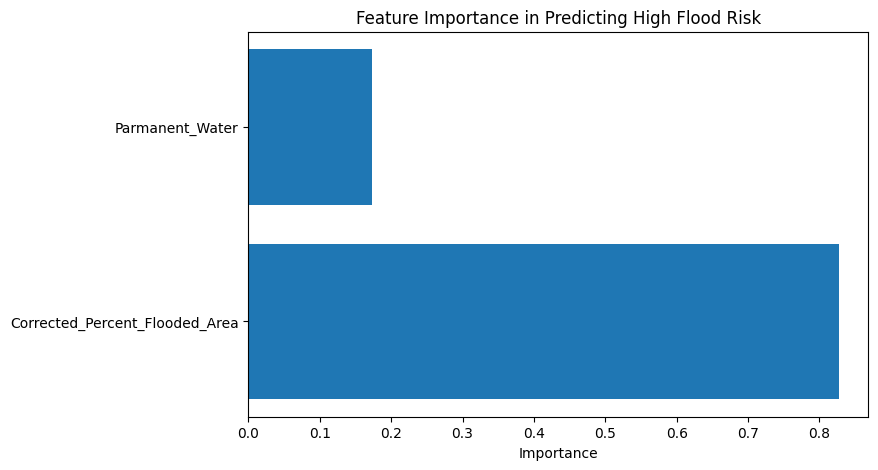

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'District_FloodedArea.csv'
df = pd.read_csv(file_path)

df.dropna(inplace=True)

threshold = df['Percent_Flooded_Area'].mean()
df['High_Flood_Risk'] = (df['Percent_Flooded_Area'] > threshold).astype(int)

X = df[['Parmanent_Water', 'Corrected_Percent_Flooded_Area']].values
y = df['High_Flood_Risk'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class RandomForestFromScratch:
    def __init__(self, n_estimators=10, max_features='sqrt', max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _get_max_features(self, n_features):
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        else:
            return n_features

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        self.trees = []

        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTreeClassifier(max_features=max_features, max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        majority_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_preds)
        return majority_vote

    def predict_proba(self, X):
        tree_probas = np.array([tree.predict_proba(X) for tree in self.trees])
        avg_probas = np.mean(tree_probas, axis=0)
        return avg_probas

custom_rf = RandomForestFromScratch(n_estimators=100, max_features='sqrt', max_depth=None, random_state=42)
custom_rf.fit(X_train, y_train)

probas = custom_rf.predict_proba(X)
df['Risk_Score'] = probas[:, 1]

if 'Dist_Name' in df.columns:
    highest_risk_area = df.loc[df['Risk_Score'].idxmax(), 'Dist_Name']
    print(f'The area most at risk for flooding is: {highest_risk_area}')
else:
    print("Column 'Dist_Name' not found in the dataset.")

y_pred = custom_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

importances = np.mean([tree.feature_importances_ for tree in custom_rf.trees], axis=0)
features = ['Parmanent_Water', 'Corrected_Percent_Flooded_Area']
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Predicting High Flood Risk')
plt.show()

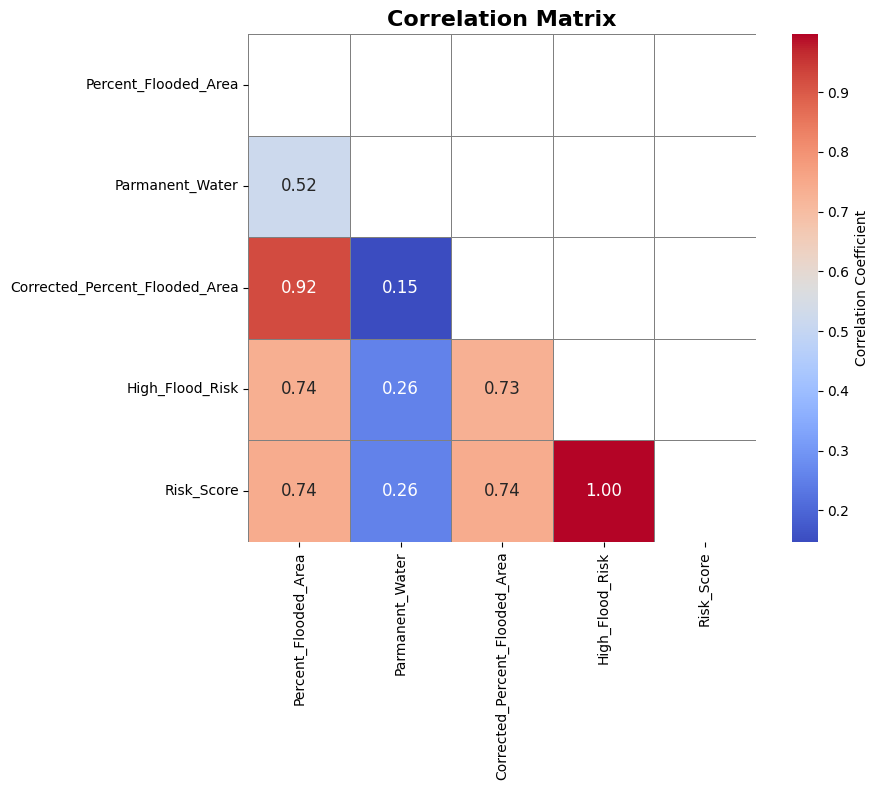

In [ ]:
numeric_df = df.select_dtypes(include=['number'])

correlation = numeric_df.corr()

plt.figure(figsize=(10, 8))

mask = np.triu(np.ones_like(correlation, dtype=bool))

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", mask=mask,
            annot_kws={'size': 12}, cbar_kws={'label': 'Correlation Coefficient'},
            linewidths=0.5, linecolor='gray', square=True)

plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()